We check if the behavior of the dynamics is truly that of a limit cycle

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import warnings

from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils

# Set default tensor type
torch.set_default_dtype(torch.float64)

In [2]:
# ---------------------
# Parameters and Setup
# ---------------------
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}

b0 = 1.0 * torch.ones(N)
b1 = 1.0 * torch.ones(N)

sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
Way = torch.ones(N, N)

In [3]:
mu = 0.0
delta = 1.0 # noise strength

Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)

In [4]:
# Time settings: simulate in chunks so that we can check for convergence.
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max = max(torch.max(tauA), torch.max(tauY))
chunk_time = 100 * tau_max      # length of one simulation chunk
dt = 0.05 * tau_min
points = int(chunk_time / dt)
t_chunk = torch.linspace(0, chunk_time, points)

In [5]:
model_name = 'delocalized'
input_norm = 0.01
initial_type = 'first_order'
z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)

# Create the model (using the recurrence variant)
model = organics.ORGaNICs2Dgeneral(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        run_jacobian=False
    )

# model = organics.ORGaNICs2DgeneralRectified(
#         params=params,
#         b0=b0,
#         b1=b1,
#         sigma=sigma,
#         tauA=tauA,
#         tauY=tauY,
#         Wyy=Wyy,
#         Way=Way,
#         z=z,
#         run_jacobian=False,
#     )

# model = organics.ORGaNICs2DgeneralRectifiedRecurrence(
#     params=params,
#     b0=b0,
#     b1=b1,
#     sigma=sigma,
#     tauA=tauA,
#     tauY=tauY,
#     Wyy=Wyy,
#     Way=Way,
#     z=z,
#     initial_type=initial_type,
#     run_jacobian=False,
# )

In [6]:
def simulate_trajectory(model, y0, max_loops=20):
    """
    Simulate a trajectory for a given initial condition y0.
    When a specific condition is encountered (diverging, fixed point,
    or oscillatory behavior), the simulation runs one more chunk and then stops.
    
    Returns:
        torch.Tensor: Full trajectory concatenated over simulation chunks.
    """
    sim_obj = sim_solution(model)
    total_traj = []
    condition_met = False
    
    for loop in range(max_loops):
        traj_segment = sim_obj.simulate(t_chunk, y0=y0)
        total_traj.append(traj_segment)
        y0 = traj_segment[-1, :]
        
        # Check for different behaviors.
        if utils.is_diverging(traj_segment):
            print("Trajectory diverges.")
            condition_met = True
        elif utils.is_fixed_point(traj_segment):
            print("Stable fixed point reached.")
            condition_met = True
        elif utils.is_periodic(np.linalg.norm(traj_segment.detach().numpy()[:, :N], axis=1)):
            print("Oscillatory (limit cycle) behavior detected.")
            condition_met = True
        
        if condition_met:
            # Run one additional simulation chunk after a condition is encountered.
            traj_segment = sim_obj.simulate(t_chunk, y0=y0)
            total_traj.append(traj_segment)
            break

    total_traj = torch.cat(total_traj, dim=0)
    return total_traj


In [7]:
# ---------------------------------------------------
# Run simulations for multiple (perturbed) conditions
# ---------------------------------------------------
num_conditions = 5  # test with 5 different initial conditions
trajectories = []
initial_conditions = []

for i in range(num_conditions):
    # Generate a baseline initial condition and add a small random perturbation.
    y0 = model.inital_conditions(initial_type=initial_type)
    noise = 0.2 * torch.randn_like(y0)
    y0_perturbed = y0 + noise
    initial_conditions.append(y0_perturbed)
    print(f"\nSimulating trajectory for initial condition {i+1}...")
    traj = simulate_trajectory(model, y0_perturbed)
    trajectories.append(traj)



Simulating trajectory for initial condition 1...
Oscillatory (limit cycle) behavior detected.

Simulating trajectory for initial condition 2...
Oscillatory (limit cycle) behavior detected.

Simulating trajectory for initial condition 3...
Oscillatory (limit cycle) behavior detected.

Simulating trajectory for initial condition 4...
Oscillatory (limit cycle) behavior detected.

Simulating trajectory for initial condition 5...
Oscillatory (limit cycle) behavior detected.


In [8]:
# -----------------------------------------------------
# Extract the final limit cycle portion from each trajectory.
# Here we assume that the final simulation chunk represents the steady state.
final_cycles = []
for traj in trajectories:
    traj_np = traj.detach().numpy()
    # Each simulation chunk contains 'points' time steps (as defined earlier)
    final_segment = traj_np[-points:]
    final_cycles.append(final_segment)


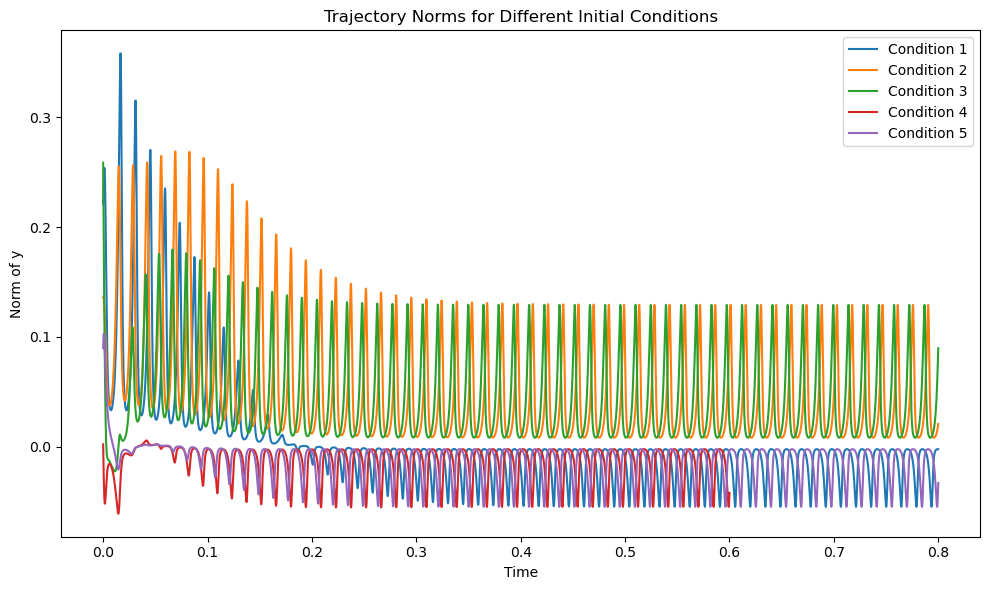

In [9]:
# --------------------------
# Visualization of results
# --------------------------
# Plot the norm of the state vector over time for each condition.
plt.figure(figsize=(10, 6))
for i, traj in enumerate(trajectories):
    traj_np = traj.detach().numpy()
    # Compute the norm using the first N entries (assumed to be the y state
    t_total = np.linspace(0, traj_np[:, 0].shape[0] * (chunk_time/points), traj_np[:, 0].shape[0])
    plt.plot(t_total, traj_np[:, 0], label=f'Condition {i+1}')
plt.xlabel('Time')
plt.ylabel('Norm of y')
plt.title('Trajectory Norms for Different Initial Conditions')
plt.legend()
plt.tight_layout()
plt.show()


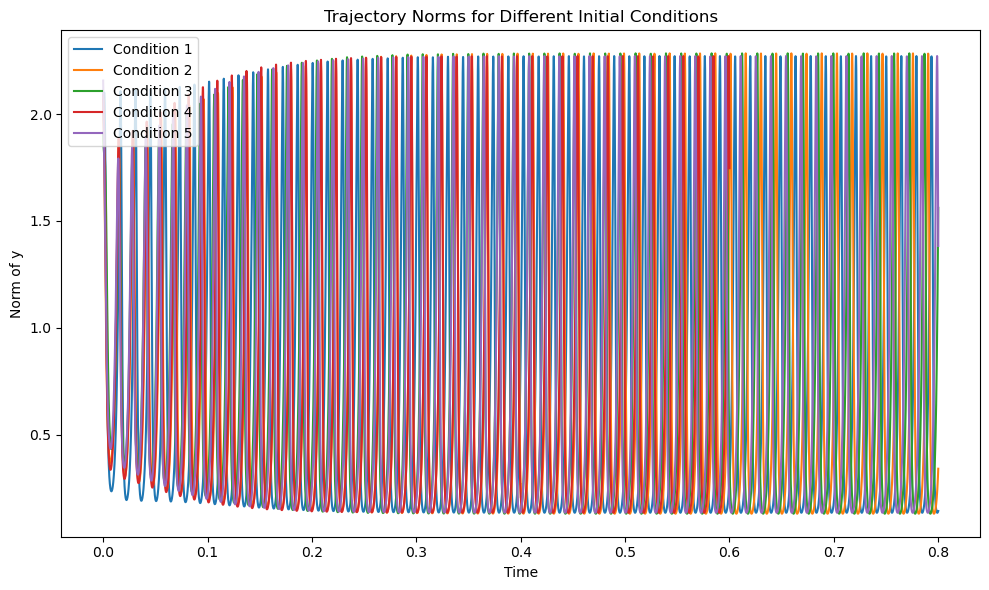

In [10]:
# --------------------------
# Visualization of results
# --------------------------
# Plot the norm of the state vector over time for each condition.
plt.figure(figsize=(10, 6))
for i, traj in enumerate(trajectories):
    traj_np = traj.detach().numpy()
    # Compute the norm using the first N entries (assumed to be the y state)
    traj_norm = np.linalg.norm(traj_np[:, :N], axis=1)
    t_total = np.linspace(0, traj_norm.shape[0] * (chunk_time/points), traj_norm.shape[0])
    plt.plot(t_total, traj_norm, label=f'Condition {i+1}')
plt.xlabel('Time')
plt.ylabel('Norm of y')
plt.title('Trajectory Norms for Different Initial Conditions')
plt.legend()
plt.tight_layout()
plt.show()


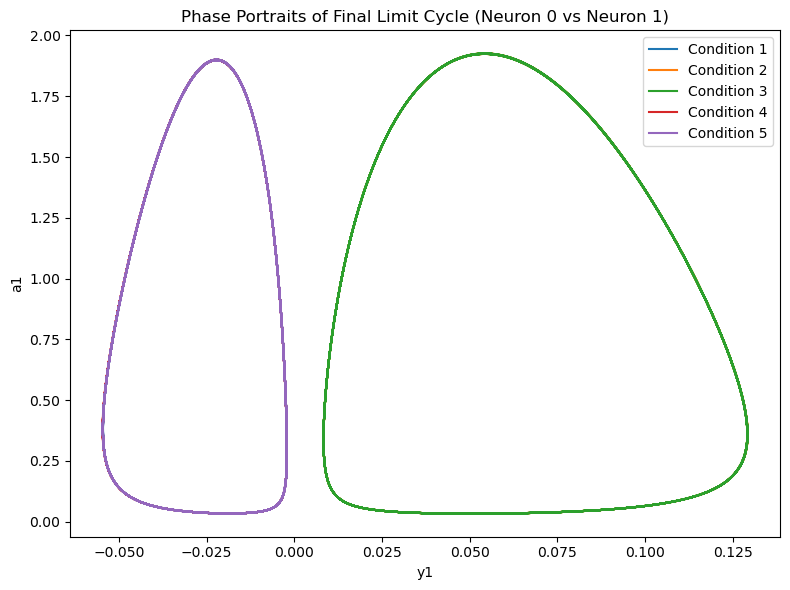

In [11]:

# Overlay phase portraits for neurons 0 (first state) vs. neuron 1 (here, the corresponding a-state is at index N)
plt.figure(figsize=(8, 6))
for i, cycle in enumerate(final_cycles):
    # Plot the phase portrait using neuron 0 and neuron 1 variables.
    # (Assuming neuron 0 is at index 0 and the second variable is stored starting at index N.)
    plt.plot(cycle[:, 0], cycle[:, N], label=f'Condition {i+1}')
plt.xlabel('y1')
plt.ylabel('a1')
plt.title('Phase Portraits of Final Limit Cycle (Neuron 0 vs Neuron 1)')
plt.legend()
plt.tight_layout()
plt.show()

